In [47]:
import MetaTrader5 as mt
import pandas as pd
import plotly.express as px
from datetime import datetime
import numpy as np
import time

In [3]:
mt.initialize()


True

In [4]:
import pytz

In [83]:
def get_1H_candles(symbol, start_date, end_date):
   
    if not mt.initialize():
        print("initialize() failed")
        mt.shutdown()
        return None

    timeframe = mt.TIMEFRAME_H1
    
    s_date = datetime.strptime(start_date, "%Y-%m-%d")
    s_year = s_date.year
    s_month = s_date.month
    s_day = s_date.day
    
    e_date = datetime.strptime(end_date, "%Y-%m-%d")
    e_year = e_date.year
    e_month = e_date.month
    e_day = e_date.day
    
    if start_date > end_date:
        print("Start date cannot be after end date")
        mt.shutdown()
        return None

    timezone = pytz.timezone("Etc/UTC")
    utc_from = datetime(s_year, s_month, s_day, tzinfo=timezone)
    utc_to = datetime(e_year, e_month, e_day, hour = 13, tzinfo=timezone)
    # get bars from USDJPY M5 within the interval of 2020.01.10 00:00 - 2020.01.11 13:00 in UTC time zone
    rates = mt.copy_rates_range(symbol, timeframe, utc_from, utc_to)

    #rates = mt.copy_rates_range("XAUUSDm", timeframe, "2023-12-01", "2024-01-01")

    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')

    mt.shutdown()
    return df

# Load data
data = get_1H_candles("XAUUSDm","2023-12-01", "2024-01-01")

In [35]:
data

,time,open,high,low,close,tick_volume,spread,real_volume
0,2023-01-02 23:00:00,1825.968,1830.460,1823.998,1829.131,2383,834,0
1,2023-01-03 00:00:00,1829.110,1831.840,1828.469,1830.585,2342,332,0
2,2023-01-03 01:00:00,1830.534,1832.330,1826.747,1828.477,4809,200,0
3,2023-01-03 02:00:00,1828.510,1839.647,1828.260,1838.329,5092,200,0
4,2023-01-03 03:00:00,1838.360,1843.079,1838.360,1841.151,4222,200,0
...,...,...,...,...,...,...,...,...
5882,2023-12-29 17:00:00,2066.070,2068.149,2064.480,2066.525,4848,199,0
5883,2023-12-29 18:00:00,2066.473,2066.520,2061.101,2064.782,6074,199,0
5884,2023-12-29 19:00:00,2064.822,2067.767,2063.983,2067.251,3359,199,0
5885,2023-12-29 20:00:00,2067.228,2067.363,2062.581,2063.150,3644,199,0


In [96]:
def prepare_data(data):
    df= data.set_index('time')
    df.index = pd.to_datetime(df.index)
    df = df.drop(columns=['tick_volume','spread','real_volume'])
    df = df.rename(columns={'open':'Open','high':'High','low':'Low','close':'Close'})
    return df



In [97]:
df = prepare_data(data)
df

,Open,High,Low,Close
time,,,,
2023-12-01 00:00:00,2040.075,2042.549,2039.809,2041.826
2023-12-01 01:00:00,2041.809,2043.370,2041.197,2041.722
2023-12-01 02:00:00,2041.671,2042.740,2039.940,2040.261
2023-12-01 03:00:00,2040.278,2042.697,2038.653,2039.410
2023-12-01 04:00:00,2039.403,2040.494,2038.808,2040.170
...,...,...,...,...
2023-12-29 17:00:00,2066.070,2068.149,2064.480,2066.525
2023-12-29 18:00:00,2066.473,2066.520,2061.101,2064.782
2023-12-29 19:00:00,2064.822,2067.767,2063.983,2067.251


In [15]:
def identify_macd_signals(df):
    """
    Calculates MACD signals for uptrend, downtrend, and trend change,
    and adds them to the input DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing financial data with a 'Close' column.

    Returns:
        pd.DataFrame: DataFrame with added columns for MACD signals.
    """

    df.ta.macd(close='Close', fast=12, slow=26, signal=9, append=True)  # Calculate MACD

    df['MACD_Signal'] = ''  # Initialize signal column

    df.loc[(df['MACD_12_26_9'] > df['MACDs_12_26_9']), 'MACD_Signal'] = 'Uptrend'
    df.loc[(df['MACD_12_26_9'] < df['MACDs_12_26_9']), 'MACD_Signal'] = 'Downtrend'

    # Identify trend change signals based on crossover
    df.loc[0, 'MACD_Signal'] = 'Initial Value'  # Set initial signal
    for i in range(1,len(df)):
        if df.loc[i, 'MACD_Signal'] != df.loc[i - 1, 'MACD_Signal']:
            df.loc[i, 'MACD_Signal'] = 'Trend Change'

    return df



data = identify_macd_signals(df)
data

C:\Users\rozir\AppData\Local\Temp\ipykernel_27992\642518094.py:13: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  df.ta.macd(close='Close', fast=12, slow=26, signal=9, append=True)  # Calculate MACD


KeyError: 1

In [28]:
df


,Open,High,Low,Close,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD_Signal
time,,,,,,,,
2023-01-02 23:00:00,1825.968,1830.460,1823.998,1829.131,NaN,NaN,NaN,
2023-01-03 00:00:00,1829.110,1831.840,1828.469,1830.585,NaN,NaN,NaN,
2023-01-03 01:00:00,1830.534,1832.330,1826.747,1828.477,NaN,NaN,NaN,
2023-01-03 02:00:00,1828.510,1839.647,1828.260,1838.329,NaN,NaN,NaN,
2023-01-03 03:00:00,1838.360,1843.079,1838.360,1841.151,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...
2023-12-29 18:00:00,2066.473,2066.520,2061.101,2064.782,-2.230299,0.062552,-2.292851,Uptrend
2023-12-29 19:00:00,2064.822,2067.767,2063.983,2067.251,-1.961719,0.264906,-2.226624,Uptrend
2023-12-29 20:00:00,2067.228,2067.363,2062.581,2063.150,-2.056082,0.136434,-2.192516,Uptrend


In [30]:
data

,time,open,high,low,close,tick_volume,spread,real_volume
0,2023-01-02 23:00:00,1825.968,1830.460,1823.998,1829.131,2383,834,0
1,2023-01-03 00:00:00,1829.110,1831.840,1828.469,1830.585,2342,332,0
2,2023-01-03 01:00:00,1830.534,1832.330,1826.747,1828.477,4809,200,0
3,2023-01-03 02:00:00,1828.510,1839.647,1828.260,1838.329,5092,200,0
4,2023-01-03 03:00:00,1838.360,1843.079,1838.360,1841.151,4222,200,0
...,...,...,...,...,...,...,...,...
5882,2023-12-29 17:00:00,2066.070,2068.149,2064.480,2066.525,4848,199,0
5883,2023-12-29 18:00:00,2066.473,2066.520,2061.101,2064.782,6074,199,0
5884,2023-12-29 19:00:00,2064.822,2067.767,2063.983,2067.251,3359,199,0
5885,2023-12-29 20:00:00,2067.228,2067.363,2062.581,2063.150,3644,199,0


In [38]:
data = prepare_data(data)
print(data)

                         Open      High       Low     Close
time                                                       
2023-01-02 23:00:00  1825.968  1830.460  1823.998  1829.131
2023-01-03 00:00:00  1829.110  1831.840  1828.469  1830.585
2023-01-03 01:00:00  1830.534  1832.330  1826.747  1828.477
2023-01-03 02:00:00  1828.510  1839.647  1828.260  1838.329
2023-01-03 03:00:00  1838.360  1843.079  1838.360  1841.151
...                       ...       ...       ...       ...
2023-12-29 17:00:00  2066.070  2068.149  2064.480  2066.525
2023-12-29 18:00:00  2066.473  2066.520  2061.101  2064.782
2023-12-29 19:00:00  2064.822  2067.767  2063.983  2067.251
2023-12-29 20:00:00  2067.228  2067.363  2062.581  2063.150
2023-12-29 21:00:00  2063.190  2063.599  2062.424  2062.838

[5887 rows x 4 columns]


In [86]:
df.ta.macd(close='Close', fast=12, slow=26, signal=9, append=True)



,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
time,,,
2023-12-01 00:00:00,NaN,NaN,NaN
2023-12-01 01:00:00,NaN,NaN,NaN
2023-12-01 02:00:00,NaN,NaN,NaN
2023-12-01 03:00:00,NaN,NaN,NaN
2023-12-01 04:00:00,NaN,NaN,NaN
...,...,...,...
2023-12-29 17:00:00,-2.289276,0.019213,-2.308489
2023-12-29 18:00:00,-2.230299,0.062552,-2.292851
2023-12-29 19:00:00,-1.961719,0.264906,-2.226624


In [81]:
df = data

In [87]:
df['MACD_Signal'] = ''  # Initialize with empty strings

df.loc[(df['MACD_12_26_9'] > df['MACDs_12_26_9']), 'MACD_Signal'] = 'Uptrend'
df.loc[(df['MACD_12_26_9'] < df['MACDs_12_26_9']), 'MACD_Signal'] = 'Downtrend'


In [44]:
df

,Open,High,Low,Close,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD_Signal
time,,,,,,,,
2023-01-02 23:00:00,1825.968,1830.460,1823.998,1829.131,NaN,NaN,NaN,
2023-01-03 00:00:00,1829.110,1831.840,1828.469,1830.585,NaN,NaN,NaN,
2023-01-03 01:00:00,1830.534,1832.330,1826.747,1828.477,NaN,NaN,NaN,
2023-01-03 02:00:00,1828.510,1839.647,1828.260,1838.329,NaN,NaN,NaN,
2023-01-03 03:00:00,1838.360,1843.079,1838.360,1841.151,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...
2023-12-29 17:00:00,2066.070,2068.149,2064.480,2066.525,-2.289276,0.019213,-2.308489,Uptrend
2023-12-29 18:00:00,2066.473,2066.520,2061.101,2064.782,-2.230299,0.062552,-2.292851,Uptrend
2023-12-29 19:00:00,2064.822,2067.767,2063.983,2067.251,-1.961719,0.264906,-2.226624,Uptrend


In [88]:
df.loc[0, 'MACD_Signal'] = 'Initial Value'  # Set initial signal
df['MACD_Signal'] = np.where(df['MACD_Signal'] != df['MACD_Signal'].shift(1), 'Trend Change', df['MACD_Signal'])


In [89]:
df

,Open,High,Low,Close,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD_Signal
time,,,,,,,,
2023-12-01 00:00:00,2040.075,2042.549,2039.809,2041.826,NaN,NaN,NaN,Trend Change
2023-12-01 01:00:00,2041.809,2043.370,2041.197,2041.722,NaN,NaN,NaN,
2023-12-01 02:00:00,2041.671,2042.740,2039.940,2040.261,NaN,NaN,NaN,
2023-12-01 03:00:00,2040.278,2042.697,2038.653,2039.410,NaN,NaN,NaN,
2023-12-01 04:00:00,2039.403,2040.494,2038.808,2040.170,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...
2023-12-29 18:00:00,2066.473,2066.520,2061.101,2064.782,-2.230299,0.062552,-2.292851,Uptrend
2023-12-29 19:00:00,2064.822,2067.767,2063.983,2067.251,-1.961719,0.264906,-2.226624,Uptrend
2023-12-29 20:00:00,2067.228,2067.363,2062.581,2063.150,-2.056082,0.136434,-2.192516,Uptrend


In [53]:
import mplfinance as mpf

In [93]:
import mplfinance as mpf

class ForexAnalyzer:
    def __init__(self, df):
        self.df = df

    def plot_macd_signals_mplfinance(self):
        """Plots 1-hour candles with MACD signals using mplfinance."""

        mc = mpf.make_marketcolors(up='green', down='red', wick='inherit',
                                   edge='inherit', volume='in')  # Set color scheme
        s  = mpf.make_mpf_style(marketcolors=mc)

        mpf.plot(self.df, type='candle', style=s,
                 title="1-Hour Forex Commodity Index with MACD Signals",
                 ylabel='Price',
                 volume=False,  # Display volume bars
                 show_nontrading=True,  # Show gaps for non-trading periods
                 figratio=(10, 6),  # Adjust figure dimensions
                 datetime_format='%Y-%m-%d %H:%M')  # Set datetime format


In [99]:
analyzer = ForexAnalyzer(df)

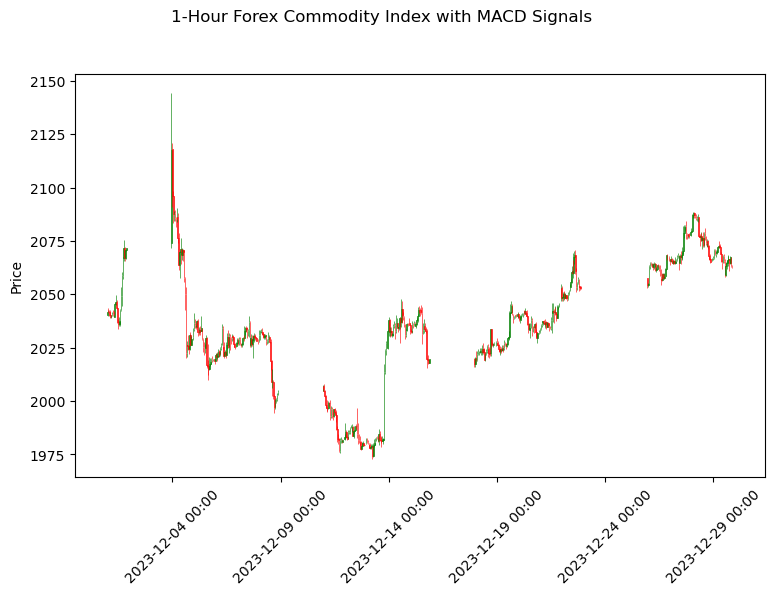

In [100]:
analyzer.plot_macd_signals_mplfinance()

In [57]:
df

,Open,High,Low,Close,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD_Signal
time,,,,,,,,
2023-01-02 23:00:00,1825.968,1830.460,1823.998,1829.131,NaN,NaN,NaN,Trend Change
2023-01-03 00:00:00,1829.110,1831.840,1828.469,1830.585,NaN,NaN,NaN,
2023-01-03 01:00:00,1830.534,1832.330,1826.747,1828.477,NaN,NaN,NaN,
2023-01-03 02:00:00,1828.510,1839.647,1828.260,1838.329,NaN,NaN,NaN,
2023-01-03 03:00:00,1838.360,1843.079,1838.360,1841.151,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...
2023-12-29 18:00:00,2066.473,2066.520,2061.101,2064.782,-2.230299,0.062552,-2.292851,Uptrend
2023-12-29 19:00:00,2064.822,2067.767,2063.983,2067.251,-1.961719,0.264906,-2.226624,Uptrend
2023-12-29 20:00:00,2067.228,2067.363,2062.581,2063.150,-2.056082,0.136434,-2.192516,Uptrend


In [98]:
print(df.index)

DatetimeIndex(['2023-12-01 00:00:00', '2023-12-01 01:00:00',
               '2023-12-01 02:00:00', '2023-12-01 03:00:00',
               '2023-12-01 04:00:00', '2023-12-01 05:00:00',
               '2023-12-01 06:00:00', '2023-12-01 07:00:00',
               '2023-12-01 08:00:00', '2023-12-01 09:00:00',
               ...
               '2023-12-29 12:00:00', '2023-12-29 13:00:00',
               '2023-12-29 14:00:00', '2023-12-29 15:00:00',
               '2023-12-29 16:00:00', '2023-12-29 17:00:00',
               '2023-12-29 18:00:00', '2023-12-29 19:00:00',
               '2023-12-29 20:00:00', '2023-12-29 21:00:00'],
              dtype='datetime64[ns]', name='time', length=459, freq=None)


In [60]:
df.index = pd.to_datetime(df.index)

ValueError: mixed datetimes and integers in passed array

In [62]:
data

,time,open,high,low,close,tick_volume,spread,real_volume
0,2023-01-02 23:00:00,1825.968,1830.460,1823.998,1829.131,2383,834,0
1,2023-01-03 00:00:00,1829.110,1831.840,1828.469,1830.585,2342,332,0
2,2023-01-03 01:00:00,1830.534,1832.330,1826.747,1828.477,4809,200,0
3,2023-01-03 02:00:00,1828.510,1839.647,1828.260,1838.329,5092,200,0
4,2023-01-03 03:00:00,1838.360,1843.079,1838.360,1841.151,4222,200,0
...,...,...,...,...,...,...,...,...
5882,2023-12-29 17:00:00,2066.070,2068.149,2064.480,2066.525,4848,199,0
5883,2023-12-29 18:00:00,2066.473,2066.520,2061.101,2064.782,6074,199,0
5884,2023-12-29 19:00:00,2064.822,2067.767,2063.983,2067.251,3359,199,0
5885,2023-12-29 20:00:00,2067.228,2067.363,2062.581,2063.150,3644,199,0


In [72]:
print(df.index)

DatetimeIndex(['2023-01-02 23:00:00', '2023-01-03 00:00:00',
               '2023-01-03 01:00:00', '2023-01-03 02:00:00',
               '2023-01-03 03:00:00', '2023-01-03 04:00:00',
               '2023-01-03 05:00:00', '2023-01-03 06:00:00',
               '2023-01-03 07:00:00', '2023-01-03 08:00:00',
               ...
               '2023-12-29 12:00:00', '2023-12-29 13:00:00',
               '2023-12-29 14:00:00', '2023-12-29 15:00:00',
               '2023-12-29 16:00:00', '2023-12-29 17:00:00',
               '2023-12-29 18:00:00', '2023-12-29 19:00:00',
               '2023-12-29 20:00:00', '2023-12-29 21:00:00'],
              dtype='datetime64[ns]', name='time', length=5887, freq=None)


In [65]:
data.index = pd.to_datetime(data.index)